In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns   

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [2]:
geo_data = gpd.read_file('dissemination.shp')
migrant_data = pd.read_csv('data/migration_profile.csv')

In [3]:
our_dissemination = migrant_data["DAUID"]
our_dissemination = our_dissemination.astype(str)

In [4]:
geo_data = geo_data[geo_data["DAUID"].isin(our_dissemination)]
geo_data = geo_data[["DAUID", "geometry"]]

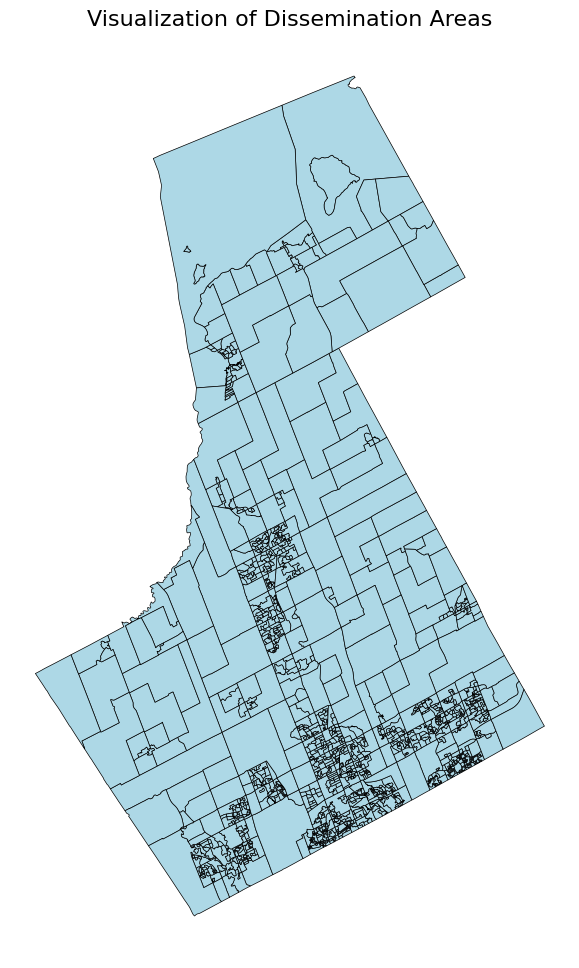

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

geo_data.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.5)

ax.set_title('Visualization of Dissemination Areas', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

ax.set_axis_off()

plt.show()


In [6]:
crime_data = pd.read_csv('data/crime_data_york_2024.csv')
crime_locations = crime_data[["x", "y"]]

In [7]:
crime_gdf = gpd.GeoDataFrame(
    crime_locations,
    geometry=gpd.points_from_xy(crime_locations.x, crime_locations.y),
    crs="EPSG:26917"         
)

crime_gdf = crime_gdf.to_crs(geo_data.crs)

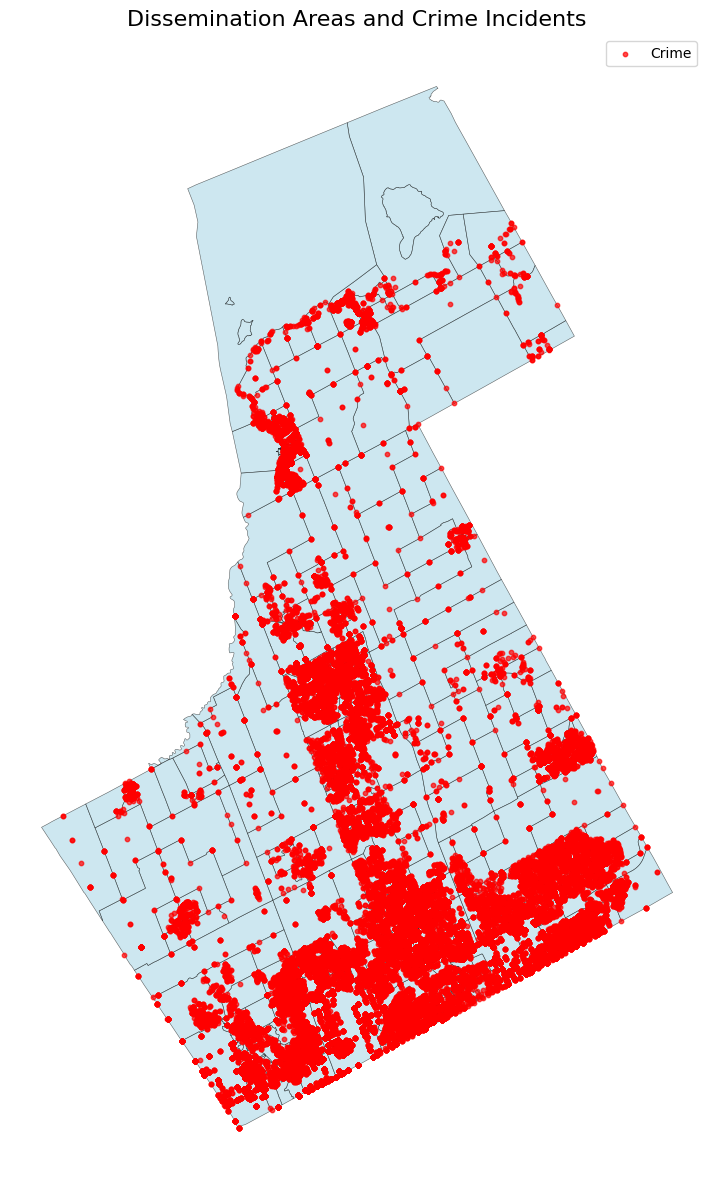

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

geo_data.plot(ax=ax, facecolor="lightblue", edgecolor="black", linewidth=0.4, alpha=0.6)
crime_gdf.plot(ax=ax, color="red", markersize=10, alpha=0.7, label="Crime")

ax.set_title("Dissemination Areas and Crime Incidents", fontsize=16)
ax.set_axis_off()
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
crime_with_da = gpd.sjoin(
    crime_gdf, 
    geo_data[["DAUID", "geometry"]], 
    how="left",              
    predicate="within"
).drop(columns=["index_right"])  

crime_data["DAUID"] = crime_with_da["DAUID"]

In [10]:
crime_data.head()

,UniqueIdentifier,Occurrence Date,Occurrence Detail,Location Code,Municipality,Special Grouping,OBJECTID,Shooting,Occurrence Number,Hate Crime,Status,Occurrence Type,Report Date,x,y,DAUID
0,2024_376_1,1/1/2024 5:56:00 PM,Mischief To Property,Outdoor,Vaughan,NaN,1419301,NaN,2024_376,NaN,Closed,Mischief,1/1/2024 12:00:00 AM,616461.7500,4.862334e+06,35191287
1,2024_642_1,1/1/2024 11:30:00 PM,Theft Under $5000 - Shoplifting,Business,Markham,NaN,1419303,NaN,2024_642,NaN,Solved,Theft Under $5000,1/1/2024 12:00:00 AM,634510.6535,4.853635e+06,35190747
2,2024_265_1,1/1/2024 11:21:00 AM,Break and Enter - Commercial,Business,Vaughan,NaN,1419304,NaN,2024_265,NaN,Closed,Break and Enter - Commercial,1/1/2024 12:00:00 AM,623098.1604,4.849384e+06,NaN
3,2024_417_2,1/1/2024 6:45:00 PM,Weapons Possession Of Firearm,Outdoor,Richmond Hill,NaN,1419305,NaN,2024_417,NaN,Solved,Firearms Violations,1/1/2024 12:00:00 AM,626128.2100,4.855781e+06,35190858
4,2024_230_1,1/1/2024 12:42:00 PM,Impaired Alcohol / Over 80 Mgs,Outdoor,King,NaN,1419306,NaN,2024_230,NaN,Solved,Impaired Operation,1/1/2024 12:00:00 AM,613813.2235,4.876456e+06,35190168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59247 entries, 0 to 59246
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UniqueIdentifier   59247 non-null  object 
 1   Occurrence Date    59247 non-null  object 
 2   Occurrence Detail  59247 non-null  object 
 3   Location Code      54761 non-null  object 
 4   Municipality       59247 non-null  object 
 5   Special Grouping   3094 non-null   object 
 6   OBJECTID           59247 non-null  int64  
 7   Shooting           96 non-null     object 
 8   Occurrence Number  59247 non-null  object 
 9   Hate Crime         320 non-null    object 
 10  Status             59247 non-null  object 
 11  Occurrence Type    59247 non-null  object 
 12  Report Date        59247 non-null  object 
 13  x                  59247 non-null  float64
 14  y                  59247 non-null  float64
 15  DAUID              58846 non-null  object 
dtypes: float64(2), int64(1

C:\Users\Patri\AppData\Local\Temp\ipykernel_126076\3367956195.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data["Occurrence Date"] = pd.to_datetime(crime_data["Occurrence Date"], errors="coerce")



Top 10 occurrence types:
                             Type  Count
0              Theft Under $5000  13629
1                          Fraud   8266
2                       Assaults   7977
3            Other Persons Crime   5906
4                       Mischief   5053
5         Theft of Motor Vehicle   3868
6           Other Property Crime   2621
7  Break and Enter - Residential   1887
8             Impaired Operation   1649
9                 Missing Person   1286

Share of incidents that involved gunfire: 0.0%
Share recorded as hate crimes:            0.0%

Top 10 municipalities:
 Municipality
Vaughan                   19477
Markham                   13132
Richmond Hill             10088
Newmarket                  5701
Aurora                     3043
Georgina                   2977
East Gwillimbury           1884
Whitchurch-Stouffville     1511
King                       1434
Name: count, dtype: int64


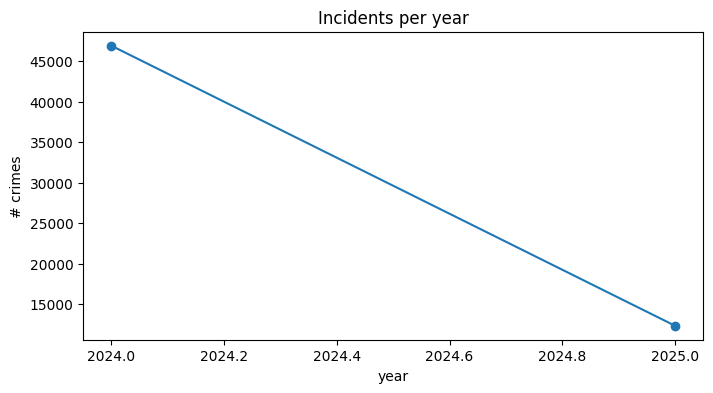

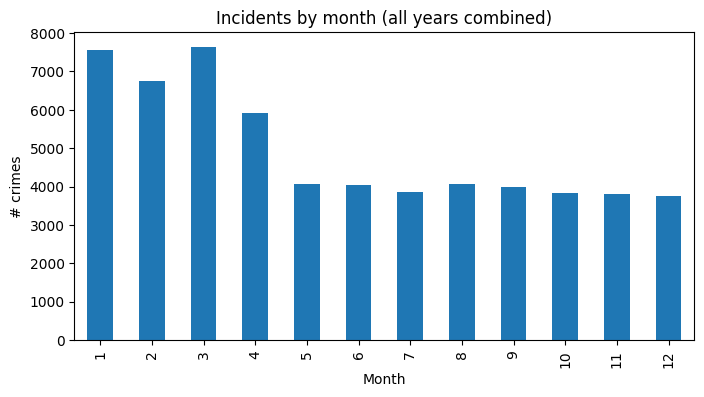

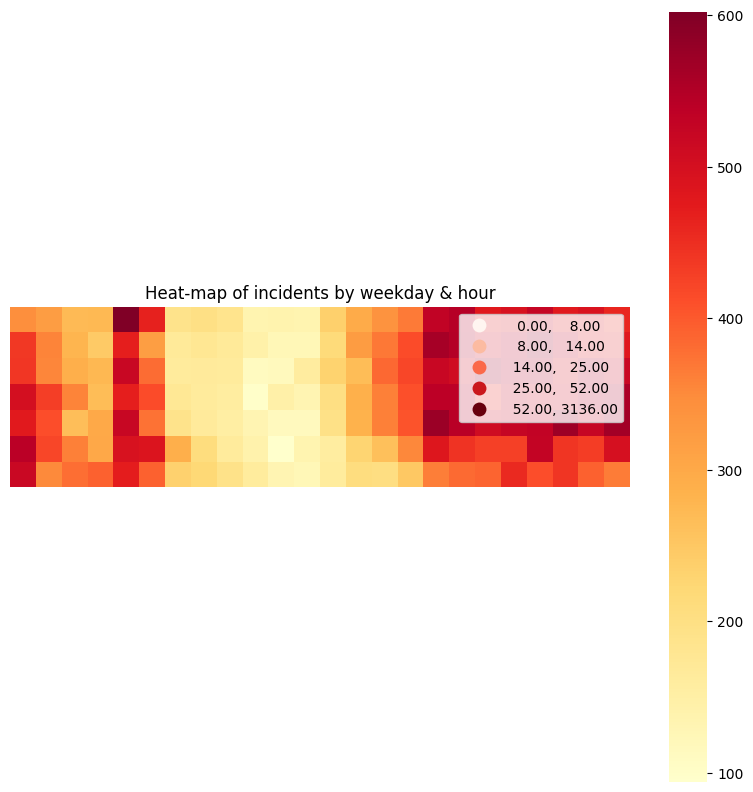

In [11]:
crime_data.info()

missing = crime_data.isna().mean().mul(100).round(1).sort_values(ascending=False)
print("\n% of missing values by column:\n", missing)

crime_data["Occurrence Date"] = pd.to_datetime(crime_data["Occurrence Date"], errors="coerce")
crime_data["year"]   = crime_data["Occurrence Date"].dt.year
crime_data["month"]  = crime_data["Occurrence Date"].dt.month
crime_data["weekday"]= crime_data["Occurrence Date"].dt.day_name()

fig, ax = plt.subplots(figsize=(8,4))
crime_data.groupby("year").size().plot(ax=ax, marker="o")
ax.set(title="Incidents per year", ylabel="# crimes")

fig, ax = plt.subplots(figsize=(8,4))
crime_data.groupby("month").size().reindex(range(1,13)).plot(kind="bar", ax=ax)
ax.set(title="Incidents by month (all years combined)", xlabel="Month", ylabel="# crimes")

top_types = (crime_data["Occurrence Type"]
             .value_counts()
             .head(10)
             .rename_axis("Type")
             .reset_index(name="Count"))
print("\nTop 10 occurrence types:\n", top_types)

shooting_rate = crime_data["Shooting"].value_counts(normalize=True).mul(100).round(1)
hate_rate     = crime_data["Hate Crime"].value_counts(normalize=True).mul(100).round(1)
print(f"\nShare of incidents that involved gunfire: {shooting_rate.get(True,0):.1f}%")
print(f"Share recorded as hate crimes:            {hate_rate.get(True,0):.1f}%")

da_counts = (crime_data["DAUID"]
             .value_counts()
             .rename_axis("DAUID")
             .reset_index(name="crime_cnt"))
muni_counts = crime_data["Municipality"].value_counts().head(10)

print("\nTop 10 municipalities:\n", muni_counts)

gdf_choro = geo_data.merge(da_counts, on="DAUID", how="left").fillna({"crime_cnt":0})
fig, ax = plt.subplots(figsize=(10,10))
gdf_choro.plot(column="crime_cnt", cmap="Reds", linewidth=0.2,
               edgecolor="grey", legend=True, scheme="quantiles",
               k=5, ax=ax)
ax.set_title("Crime count per Dissemination Area")
ax.set_axis_off()

if crime_data["Occurrence Date"].dt.hour.notna().any():
    crime_data["hour"] = crime_data["Occurrence Date"].dt.hour
    pivot = (crime_data
             .pivot_table(index="weekday", columns="hour", values="UniqueIdentifier",
                          aggfunc="count")
             .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]))
    sns.heatmap(pivot, cmap="YlOrRd")
    plt.title("Heat‑map of incidents by weekday & hour")
    plt.xlabel("Hour of day"); plt.ylabel("")
    plt.show()

In [12]:
sorted(crime_data["Occurrence Type"].dropna().unique())
crime_data["Occurrence Type"].value_counts().rename_axis("Type").reset_index(name="Count")


,Type,Count
0,Theft Under $5000,13629
1,Fraud,8266
2,Assaults,7977
3,Other Persons Crime,5906
4,Mischief,5053
5,Theft of Motor Vehicle,3868
6,Other Property Crime,2621
7,Break and Enter - Residential,1887
8,Impaired Operation,1649
9,Missing Person,1286


In [13]:
severity_map = {
    "Homicide": 10,
    "Attempt Murder": 9,
    "Firearms Violations": 9,
    "Weapons Violations": 8,
    "Robbery": 8,
    "Sexual Violations": 8,
    "Assaults": 7,
    "Other Persons Crime": 6,
    "Break and Enter - Residential": 6,
    "Break and Enter - Commercial": 6,
    "Break and Enter - Other": 6,
    "Arson": 6,
    "Theft of Motor Vehicle": 5,
    "Theft Over $5000": 5,
    "Impaired Operation": 5,
    "Drug Violations": 4,
    "Other Criminal Code": 4,
    "Fraud": 3,
    "Theft Under $5000": 3,
    "Mischief": 3,
    "Other Property Crime": 3,
    "Provincial Offences": 2,
    "Cannabis Act": 2,
    "Public Morals": 2,
    "Missing Person": 1,
}

crime_data["severity"] = crime_data["Occurrence Type"].map(severity_map)
da_safety = (crime_data
             .groupby("DAUID")["severity"]
             .mean()
             .reset_index(name="safety_score"))

geo_data = geo_data.merge(da_safety, on="DAUID", how="left").fillna({"safety_score": 0})

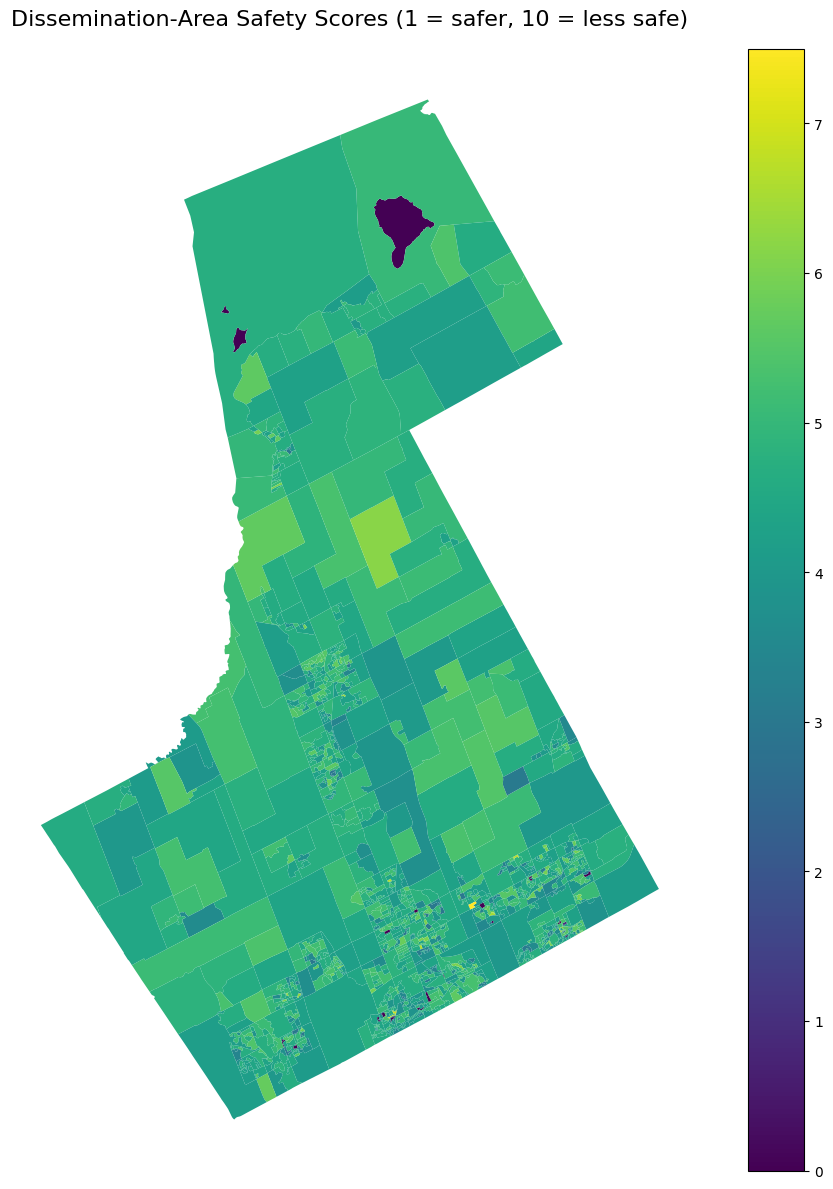

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
geo_data.plot(column="safety_score", legend=True, ax=ax)
ax.set_title("Dissemination‑Area Safety Scores (1 = safer, 10 = less safe)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [15]:
age_sex_columns_to_keep = [
    "DAUID",
    "TOT_POP",
    "TOT_0_TO_14_YRS",
    "TOT_AVG_AGE_POP",
    "M_TOTAL",
    "F_TOTAL"
]


age_sex_data = pd.read_csv("data/age_and_sex_profile.csv")
age_sex_data = age_sex_data[age_sex_columns_to_keep]

In [16]:
age_sex_data["MEN_TO_WOMEN_RATIO"] = age_sex_data["M_TOTAL"]/age_sex_data["F_TOTAL"]
age_sex_data = age_sex_data.drop(columns=["M_TOTAL", "F_TOTAL"])

In [17]:
education_cols_to_keep = [
    "DAUID",
    "NO_DIPLOMA_DEGREE_15",
    "SECONDARY_HIGH_HS_15",
    "POSTSECONDARY_DEGREE_15",
]

education_data = pd.read_csv("data/education_profile.csv")
education_data = education_data[education_cols_to_keep]

In [18]:
household_cols_to_keep = [
    "DAUID",
    "AVG_MONTHLY_SHELTER_COST_RENT",
]

household_data = pd.read_csv("data/housing_profile.csv")
household_data = household_data[household_cols_to_keep]
household_data = household_data.rename(columns={"AVG_MONTHLY_SHELTER_COST_RENT": "AVG_RENT"})

In [19]:
income_cols_to_keep = [
    "DAUID",
    "MEDIAN_TOT_INC",
]

income_data = pd.read_csv("data/income_profile.csv")
income_data = income_data[income_cols_to_keep]
income_data = income_data.rename(columns={"MEDIAN_TOT_INC": "MEDIAN_INCOME"})

In [20]:
marital_status_cols_to_keep = [
    "DAUID",
    "LONEPARENT_HH",
    "POP_15YR_PLUS_BY_MARITAL_STAT",
]

marital_status_data = pd.read_csv("data/marital_profile.csv")
marital_status_data = marital_status_data[marital_status_cols_to_keep]
marital_status_data = marital_status_data.rename(columns={
                                                        "POP_15YR_PLUS_BY_MARITAL_STAT": "TOTAL_MARRIED",
                                                        "LONEPARENT_HH": "SINGLE_PARENT_HH",
                                                          })
marital_status_data["SINGLE_PARENT_HH"] = marital_status_data["SINGLE_PARENT_HH"].fillna(0)

In [21]:
employment_cols_to_keep = [
    "DAUID",
    "UNEMPLOYMENT_RATE",
]

employment_data = pd.read_csv("data/labour_profile.csv")
employment_data = employment_data[employment_cols_to_keep]

In [22]:
migration_cols_to_keep = [
    "DAUID",
    "MS5_EXTERNAL_MIGRANT",
]

migration_data = pd.read_csv("data/migration_profile.csv")
migration_data["MIGRANT_RATE"] = migration_data["MS5_EXTERNAL_MIGRANT"]/migration_data["TOT_MOBILITY_STATUS_5YR_AGO"]
migration_data["MIGRANT_RATE"] = migration_data["MIGRANT_RATE"].fillna(0)
migration_data = migration_data[["DAUID", "MIGRANT_RATE"]]

In [23]:
merged_df = geo_data[["DAUID", "safety_score"]].copy()
merged_df = merged_df.rename(columns={"safety_score": "SAFETY_SCORE"})
merged_df["DAUID"] = merged_df["DAUID"].astype(int)

merged_df = merged_df.merge(age_sex_data, on="DAUID", how="left")
merged_df = merged_df.merge(education_data, on="DAUID", how="left")
merged_df = merged_df.merge(household_data, on="DAUID", how="left")
merged_df = merged_df.merge(income_data, on="DAUID", how="left")
merged_df = merged_df.merge(marital_status_data, on="DAUID", how="left")
merged_df = merged_df.merge(employment_data, on="DAUID", how="left")
merged_df = merged_df.merge(migration_data, on="DAUID", how="left")

In [24]:
print("Missing values per column before imputation:")
print(merged_df.isna().sum())

numeric_cols = merged_df.select_dtypes(include=["number"]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].apply(lambda col: col.fillna(col.median()))

print("\nMissing values per column after imputation:")
print(merged_df.isna().sum())

Missing values per column before imputation:
DAUID                        0
SAFETY_SCORE                 0
TOT_POP                      4
TOT_0_TO_14_YRS              4
TOT_AVG_AGE_POP              4
MEN_TO_WOMEN_RATIO           4
NO_DIPLOMA_DEGREE_15         5
SECONDARY_HIGH_HS_15         5
POSTSECONDARY_DEGREE_15      5
AVG_RENT                   474
MEDIAN_INCOME               38
SINGLE_PARENT_HH             0
TOTAL_MARRIED                4
UNEMPLOYMENT_RATE            5
MIGRANT_RATE                 0
dtype: int64

Missing values per column after imputation:
DAUID                      0
SAFETY_SCORE               0
TOT_POP                    0
TOT_0_TO_14_YRS            0
TOT_AVG_AGE_POP            0
MEN_TO_WOMEN_RATIO         0
NO_DIPLOMA_DEGREE_15       0
SECONDARY_HIGH_HS_15       0
POSTSECONDARY_DEGREE_15    0
AVG_RENT                   0
MEDIAN_INCOME              0
SINGLE_PARENT_HH           0
TOTAL_MARRIED              0
UNEMPLOYMENT_RATE          0
MIGRANT_RATE              

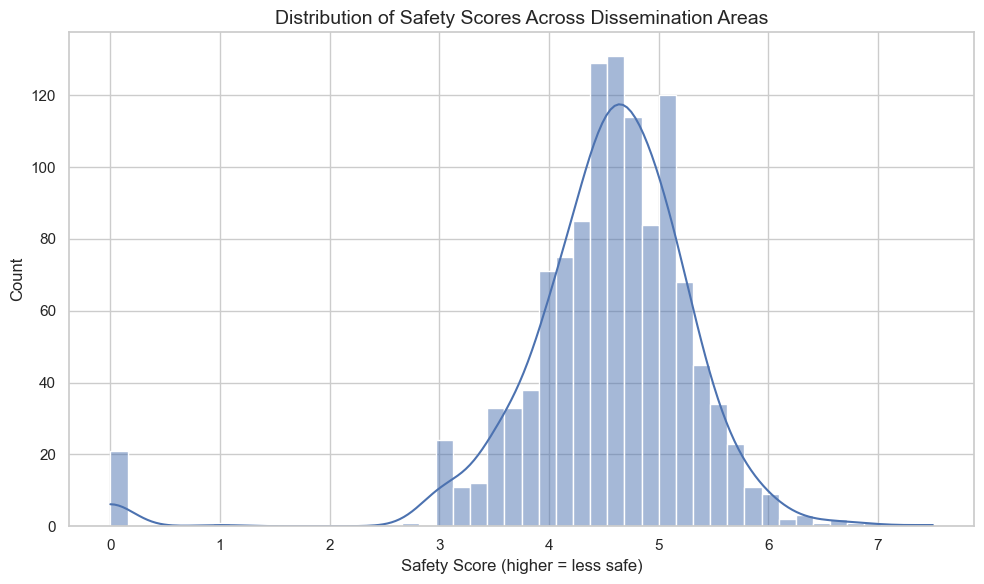

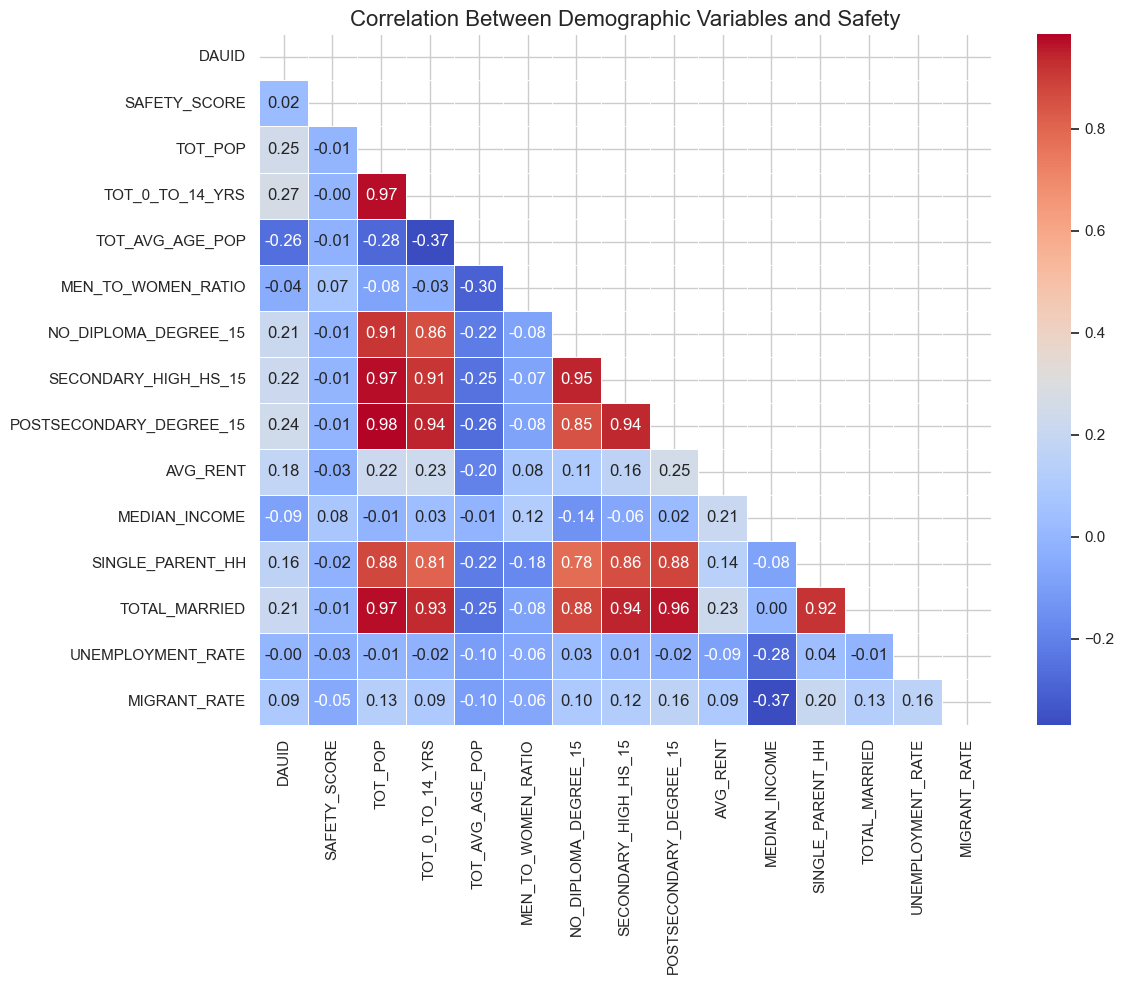

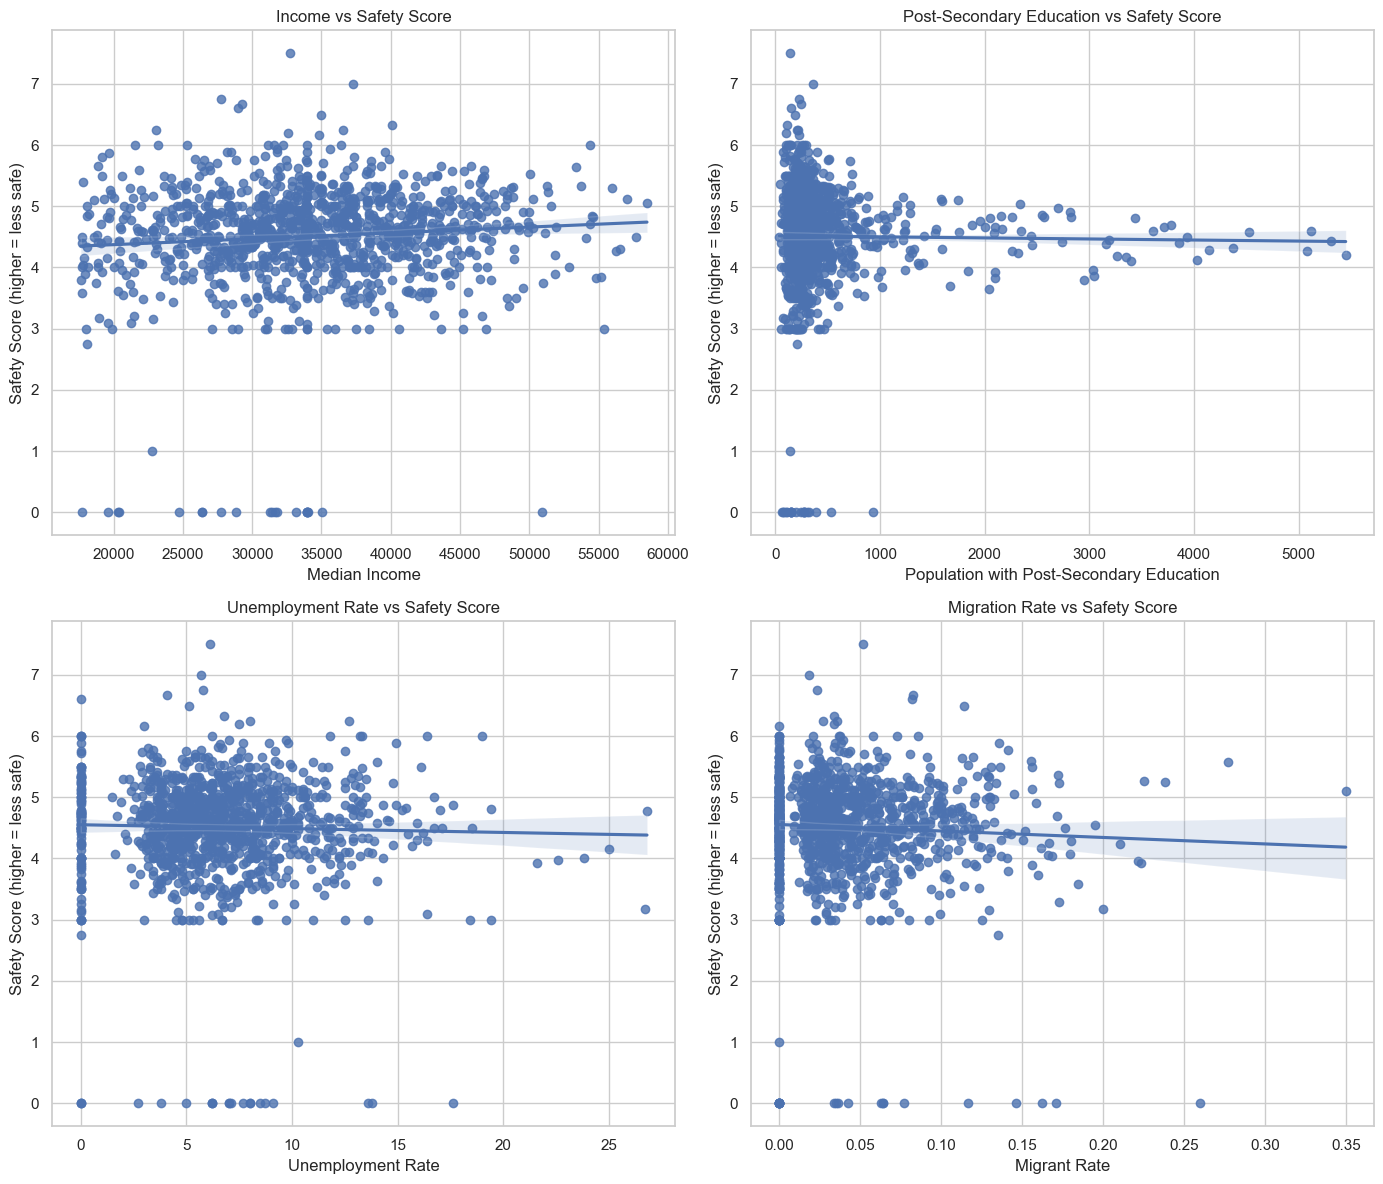

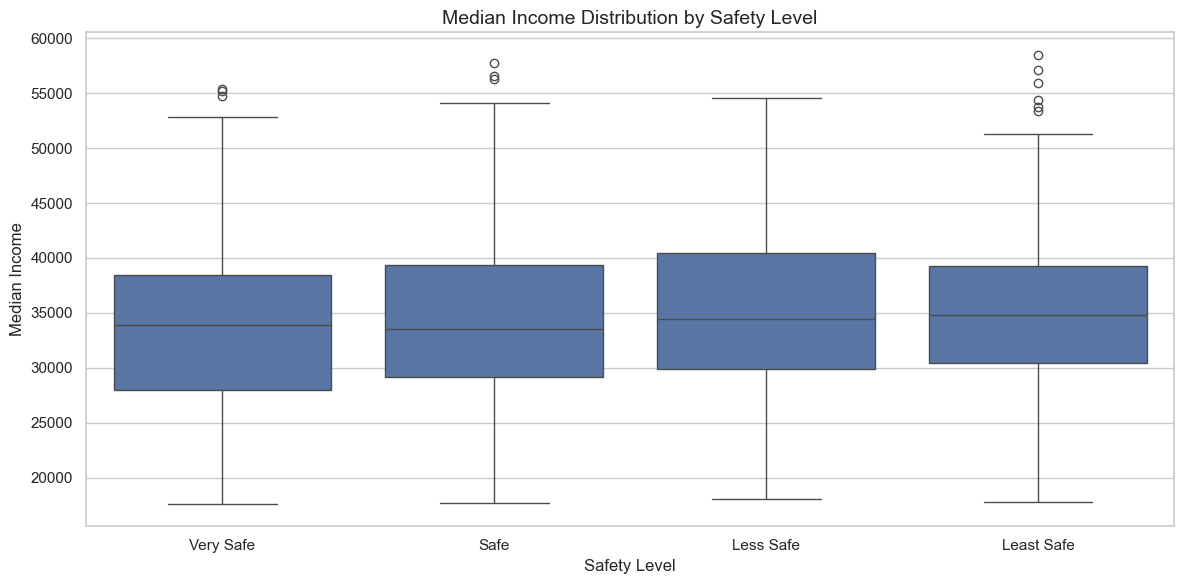

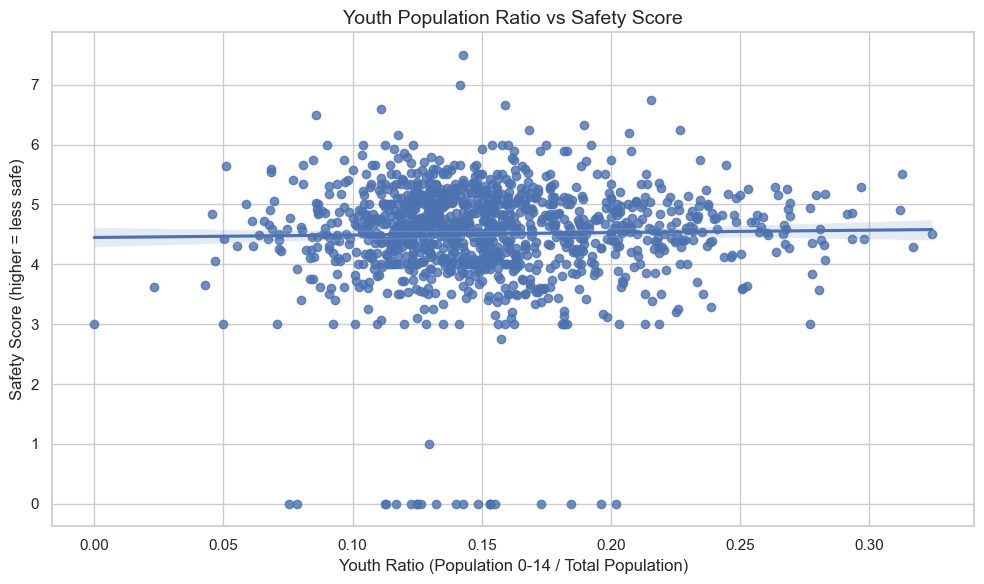

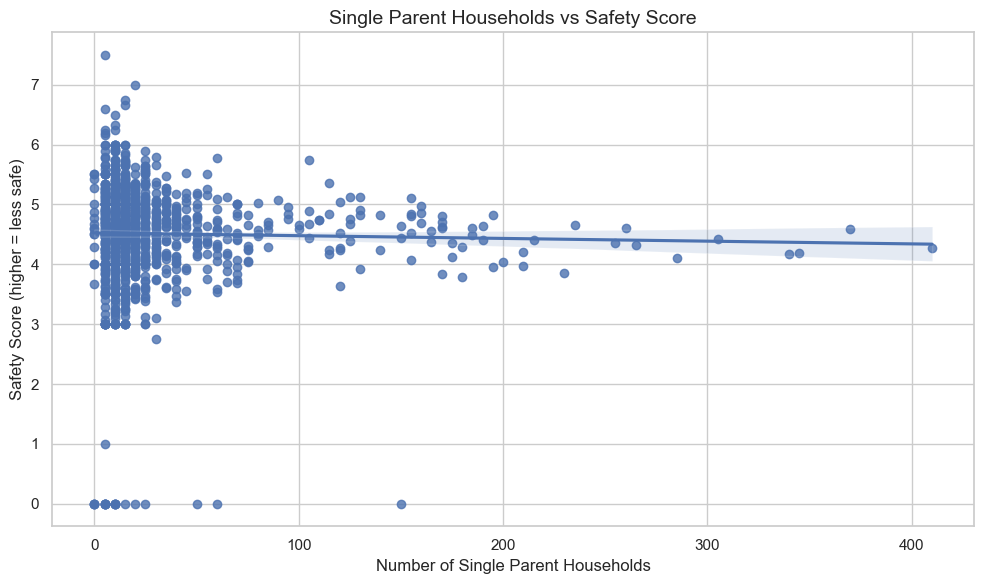

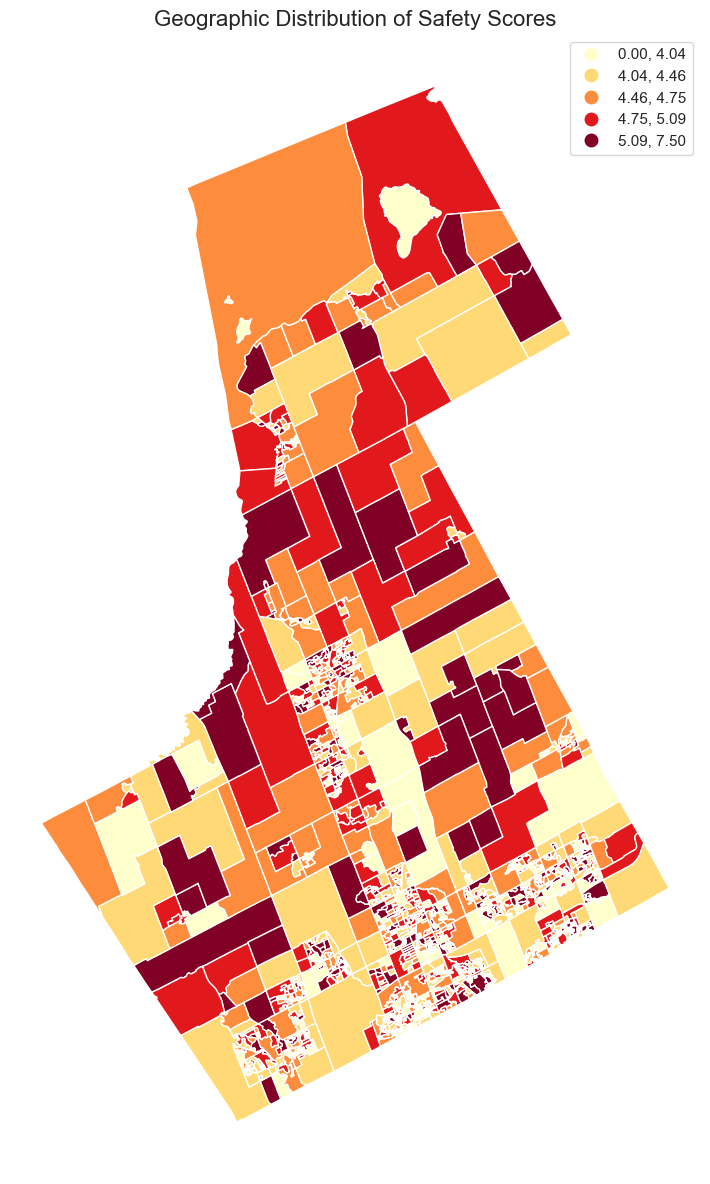

In [25]:
geo_data["DAUID"] = geo_data["DAUID"].astype(int)
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x="SAFETY_SCORE", kde=True)
plt.title("Distribution of Safety Scores Across Dissemination Areas", fontsize=14)
plt.xlabel("Safety Score (higher = less safe)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
correlation = merged_df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, linewidths=0.5)
plt.title("Correlation Between Demographic Variables and Safety", fontsize=16)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.regplot(data=merged_df, x="MEDIAN_INCOME", y="SAFETY_SCORE", ax=axes[0, 0])
axes[0, 0].set_title("Income vs Safety Score")
axes[0, 0].set_xlabel("Median Income")
axes[0, 0].set_ylabel("Safety Score (higher = less safe)")

sns.regplot(data=merged_df, x="POSTSECONDARY_DEGREE_15", y="SAFETY_SCORE", ax=axes[0, 1])
axes[0, 1].set_title("Post-Secondary Education vs Safety Score")
axes[0, 1].set_xlabel("Population with Post-Secondary Education")
axes[0, 1].set_ylabel("Safety Score (higher = less safe)")

sns.regplot(data=merged_df, x="UNEMPLOYMENT_RATE", y="SAFETY_SCORE", ax=axes[1, 0])
axes[1, 0].set_title("Unemployment Rate vs Safety Score")
axes[1, 0].set_xlabel("Unemployment Rate")
axes[1, 0].set_ylabel("Safety Score (higher = less safe)")

sns.regplot(data=merged_df, x="MIGRANT_RATE", y="SAFETY_SCORE", ax=axes[1, 1])
axes[1, 1].set_title("Migration Rate vs Safety Score")
axes[1, 1].set_xlabel("Migrant Rate")
axes[1, 1].set_ylabel("Safety Score (higher = less safe)")

plt.tight_layout()
plt.show()

merged_df["SAFETY_LEVEL"] = pd.qcut(merged_df["SAFETY_SCORE"], 
                                  q=4, 
                                  labels=["Very Safe", "Safe", "Less Safe", "Least Safe"])

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_df, x="SAFETY_LEVEL", y="MEDIAN_INCOME")
plt.title("Median Income Distribution by Safety Level", fontsize=14)
plt.xlabel("Safety Level")
plt.ylabel("Median Income")
plt.tight_layout()
plt.show()

merged_df["YOUTH_RATIO"] = merged_df["TOT_0_TO_14_YRS"] / merged_df["TOT_POP"]
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x="YOUTH_RATIO", y="SAFETY_SCORE")
plt.title("Youth Population Ratio vs Safety Score", fontsize=14)
plt.xlabel("Youth Ratio (Population 0-14 / Total Population)")
plt.ylabel("Safety Score (higher = less safe)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x="SINGLE_PARENT_HH", y="SAFETY_SCORE")
plt.title("Single Parent Households vs Safety Score", fontsize=14)
plt.xlabel("Number of Single Parent Households")
plt.ylabel("Safety Score (higher = less safe)")
plt.tight_layout()
plt.show()

geo_data_with_features = geo_data.merge(
    merged_df[["DAUID", "SAFETY_SCORE", "MEDIAN_INCOME", "UNEMPLOYMENT_RATE"]], 
    on="DAUID", 
    how="inner"
)

fig, ax = plt.subplots(figsize=(12, 12))
geo_data_with_features.plot(
    column="SAFETY_SCORE", 
    cmap="YlOrRd",
    legend=True,
    scheme="quantiles",
    k=5,
    ax=ax
)
ax.set_title("Geographic Distribution of Safety Scores", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Model accuracy: 0.5421348314606742

Confusion Matrix:
[[ 89  96]
 [ 67 104]]

Classification Report:
              precision    recall  f1-score   support

       Safer       0.57      0.48      0.52       185
   Less Safe       0.52      0.61      0.56       171

    accuracy                           0.54       356
   macro avg       0.55      0.54      0.54       356
weighted avg       0.55      0.54      0.54       356


Feature Importance:
                   Feature  Coefficient
0            MEDIAN_INCOME     0.214429
5     NO_DIPLOMA_DEGREE_15     0.166481
2       MEN_TO_WOMEN_RATIO     0.126024
8         SINGLE_PARENT_HH    -0.000019
4             MIGRANT_RATE    -0.013976
1          TOT_AVG_AGE_POP    -0.041358
3        UNEMPLOYMENT_RATE    -0.102722
7                 AVG_RENT    -0.143261
6  POSTSECONDARY_DEGREE_15    -0.246009


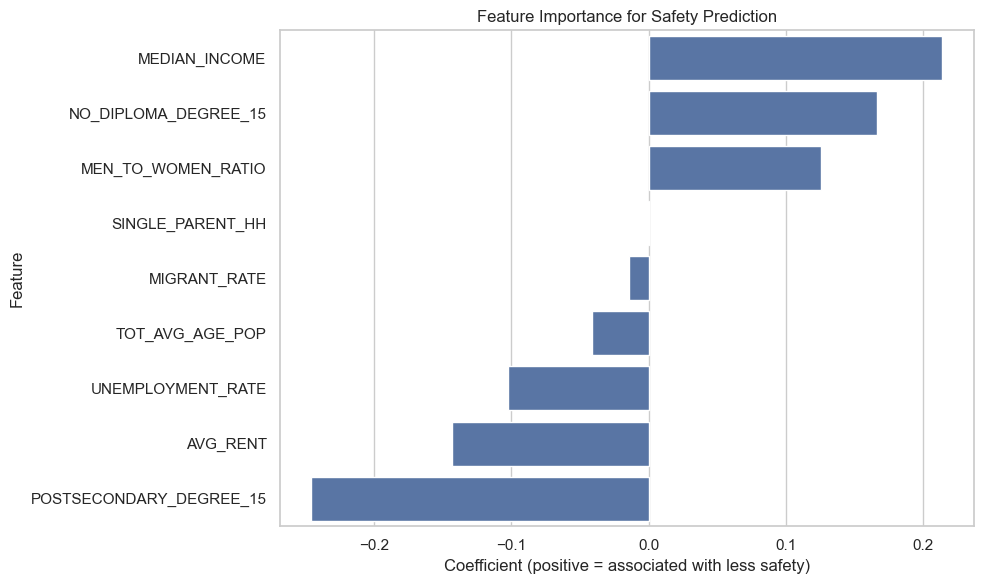

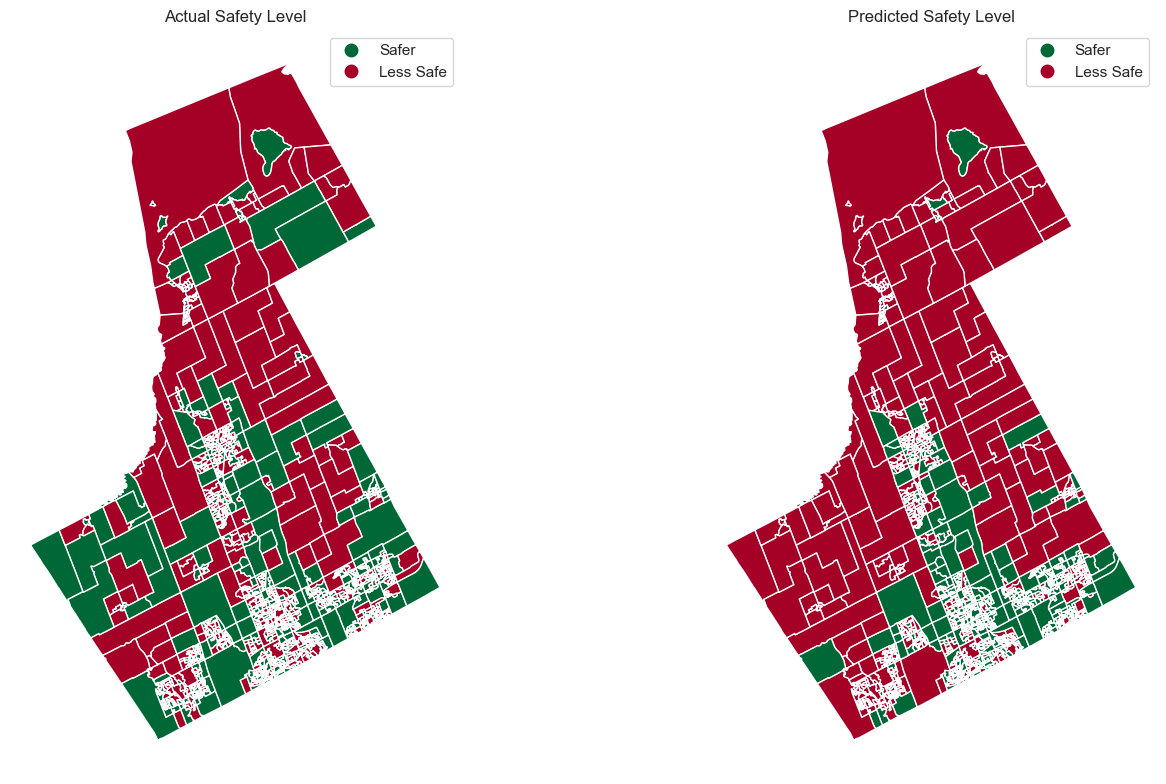

In [26]:
median_safety = merged_df['SAFETY_SCORE'].median()
merged_df['SAFETY_BINARY'] = (merged_df['SAFETY_SCORE'] > median_safety).astype(int)

features = [
    'MEDIAN_INCOME', 
    'TOT_AVG_AGE_POP', 
    'MEN_TO_WOMEN_RATIO',
    'UNEMPLOYMENT_RATE',
    'MIGRANT_RATE',
    'NO_DIPLOMA_DEGREE_15',
    'POSTSECONDARY_DEGREE_15',
    'AVG_RENT',
    'SINGLE_PARENT_HH'
]

X = merged_df[features]
y = merged_df['SAFETY_BINARY']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

print("Model accuracy:", pipe.score(X_test, y_test))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Safer', 'Less Safe']))

coefficients = pipe.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance for Safety Prediction')
plt.xlabel('Coefficient (positive = associated with less safety)')
plt.tight_layout()
plt.show()

geo_data_with_predictions = geo_data.copy()
geo_data_with_predictions['DAUID'] = geo_data_with_predictions['DAUID'].astype(int)
merged_with_predictions = merged_df[['DAUID', 'SAFETY_SCORE', 'SAFETY_BINARY']].copy()

merged_with_predictions['PREDICTED_SAFETY'] = pipe.predict(X)

geo_data_map = geo_data_with_predictions.merge(merged_with_predictions, on='DAUID', how='left')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

geo_data_map.plot(
    column='SAFETY_BINARY',
    ax=axes[0],
    cmap='RdYlGn_r',  
    legend=True,
    categorical=True,
    legend_kwds={'labels': ['Safer', 'Less Safe']}
)
axes[0].set_title('Actual Safety Level')
axes[0].set_axis_off()

geo_data_map.plot(
    column='PREDICTED_SAFETY',
    ax=axes[1],
    cmap='RdYlGn_r',
    legend=True,
    categorical=True,
    legend_kwds={'labels': ['Safer', 'Less Safe']}
)
axes[1].set_title('Predicted Safety Level')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

In [27]:
import numpy as np
import pandas as pd

scaler = pipe.named_steps['scaler']          
clf     = pipe.named_steps['classifier']    

coef_scaled   = clf.coef_[0]               
intercept_scaled = clf.intercept_[0]         

coef_raw = coef_scaled / scaler.scale_
intercept_raw = intercept_scaled - (coef_scaled * scaler.mean_ / scaler.scale_).sum()

weights = pd.DataFrame({
    "Feature"      : features,
    "β_scaled"     : coef_scaled,
    "β_unscaled"   : coef_raw
}).sort_values("β_unscaled", ascending=False)

print("\nLogistic‑regression weights (scaled & unscaled):")
print(weights.to_string(index=False, float_format="%.4f"))

print(f"\nIntercept (scaled)   : {intercept_scaled:.4f}")
print(f"Intercept (unscaled) : {intercept_raw:.4f}")

terms = "  +  ".join([f"{c:+.4f}·{f}" for c, f in zip(coef_raw, features)])
equation = f"logit(P) = {intercept_raw:+.4f}  +  {terms}"
print("\nFull decision function in original units:")
print(equation)



Logistic‑regression weights (scaled & unscaled):
                Feature  β_scaled  β_unscaled
     MEN_TO_WOMEN_RATIO    0.1260      1.3924
   NO_DIPLOMA_DEGREE_15    0.1665      0.0010
          MEDIAN_INCOME    0.2144      0.0000
       SINGLE_PARENT_HH   -0.0000     -0.0000
               AVG_RENT   -0.1433     -0.0003
POSTSECONDARY_DEGREE_15   -0.2460     -0.0004
        TOT_AVG_AGE_POP   -0.0414     -0.0085
      UNEMPLOYMENT_RATE   -0.1027     -0.0282
           MIGRANT_RATE   -0.0140     -0.3178

Intercept (scaled)   : 0.0337
Intercept (unscaled) : -1.0292

Full decision function in original units:
logit(P) = -1.0292  +  +0.0000·MEDIAN_INCOME  +  -0.0085·TOT_AVG_AGE_POP  +  +1.3924·MEN_TO_WOMEN_RATIO  +  -0.0282·UNEMPLOYMENT_RATE  +  -0.3178·MIGRANT_RATE  +  +0.0010·NO_DIPLOMA_DEGREE_15  +  -0.0004·POSTSECONDARY_DEGREE_15  +  -0.0003·AVG_RENT  +  -0.0000·SINGLE_PARENT_HH


C:\Users\Patri\AppData\Local\Temp\ipykernel_126076\3843673019.py:6: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
C:\Users\Patri\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


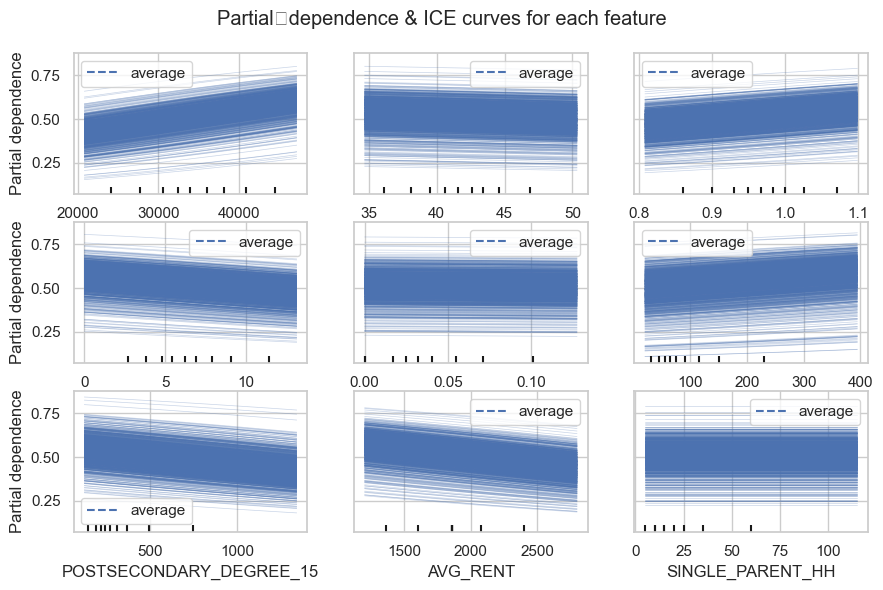

In [28]:
fig, ax = plt.subplots(figsize=(9,6))
PartialDependenceDisplay.from_estimator(
        pipe, X, features, kind='both',
        grid_resolution=50, ax=ax, n_cols=3)
fig.suptitle('Partial‑dependence & ICE curves for each feature')
plt.tight_layout(); plt.show()


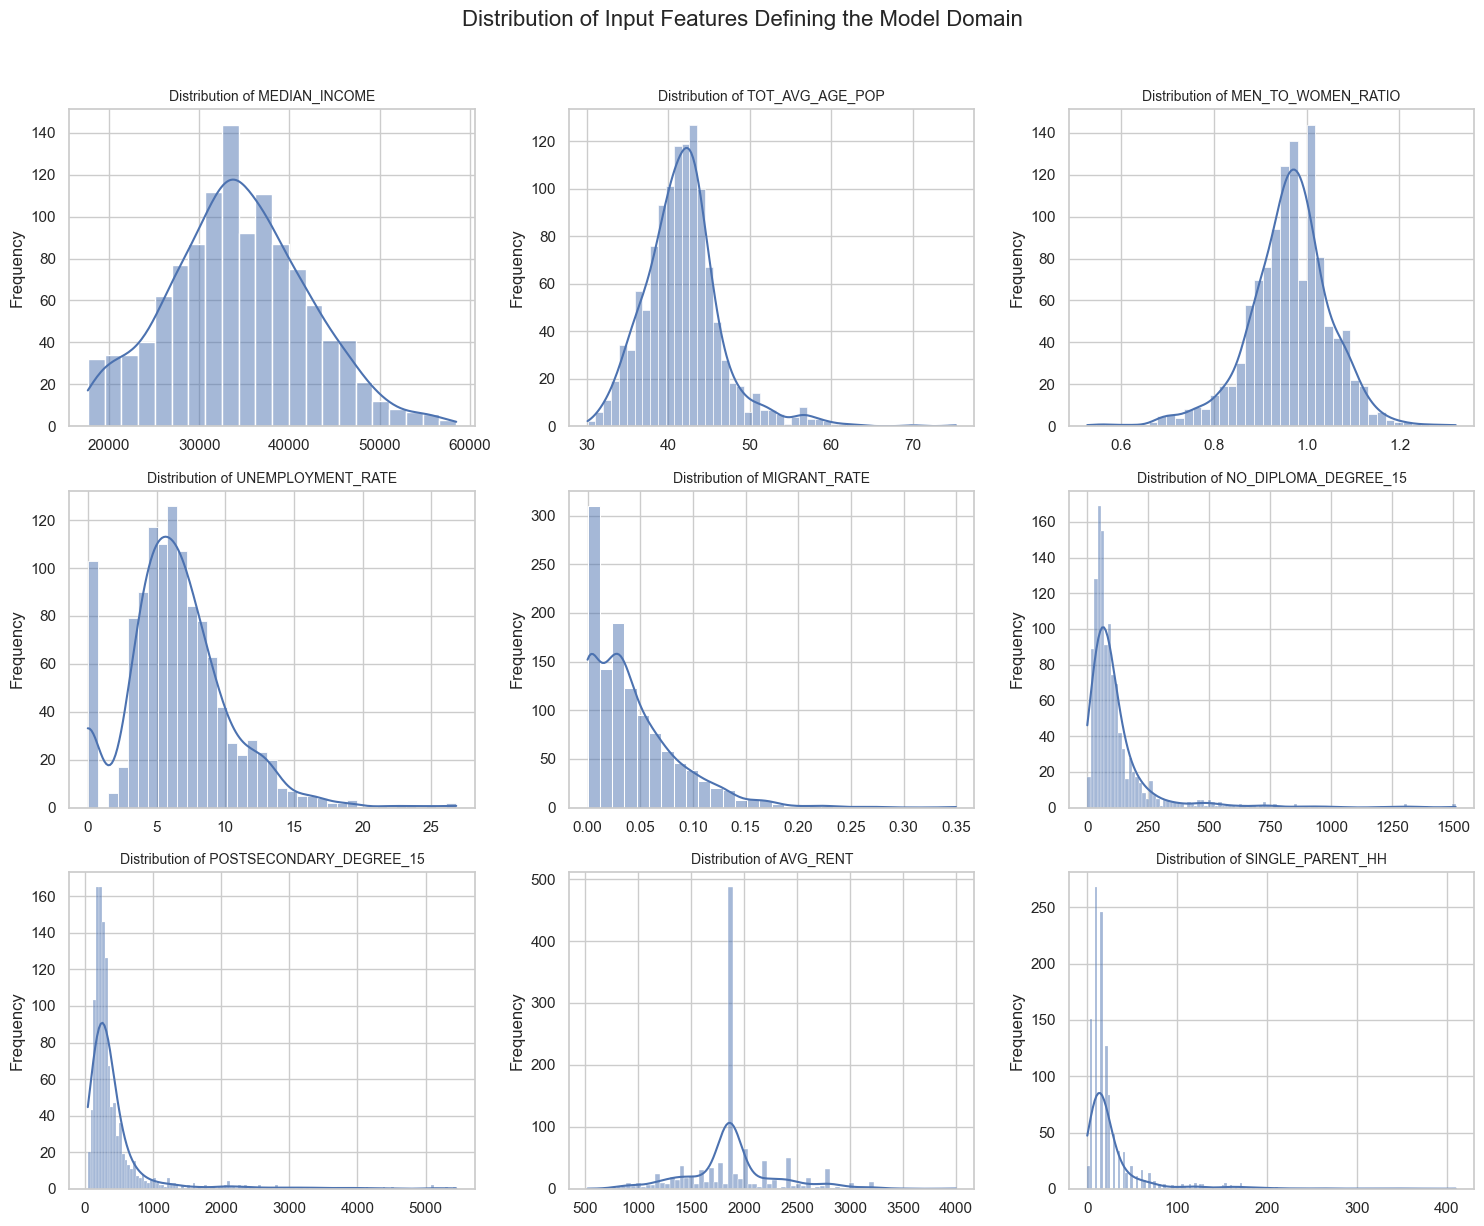

In [30]:
# Add this code to a new cell in your Jupyter Notebook

import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Ensure the figures directory exists
if not os.path.exists('figures'):
    os.makedirs('figures')

# Features used in the model (ensure this list is correct and matches your model)
features = [
    'MEDIAN_INCOME',
    'TOT_AVG_AGE_POP',
    'MEN_TO_WOMEN_RATIO',
    'UNEMPLOYMENT_RATE',
    'MIGRANT_RATE',
    'NO_DIPLOMA_DEGREE_15',
    'POSTSECONDARY_DEGREE_15',
    'AVG_RENT',
    'SINGLE_PARENT_HH'
]

# Calculate grid size for subplots
n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Plot distribution for each feature
for i, feature in enumerate(features):
    if feature in merged_df.columns:
        sns.histplot(data=merged_df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}', fontsize=10)
        axes[i].set_xlabel('') # Keep axis labels clean
        axes[i].set_ylabel('Frequency')
    else:
        axes[i].set_title(f'{feature} not found', fontsize=10)
        axes[i].axis('off') # Turn off axis if feature not found

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and save the figure
plt.suptitle('Distribution of Input Features Defining the Model Domain', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('figures/feature_distributions.png', bbox_inches='tight')
plt.show()
